# Indoor Climbing Gym Hold Segmentation

First, we install the Facebook [detectron2](https://github.com/facebookresearch/detectron2) framework.

In [1]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!python -m pip install -e ./

Cloning into 'detectron2'...
remote: Enumerating objects: 15777, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15777 (delta 7), reused 21 (delta 4), pack-reused 15743 (from 1)
Receiving objects: 100% (15777/15777), 6.35 MiB | 19.06 MiB/s, done.
Resolving deltas: 100% (11501/11501), done.
/kaggle/working/detectron2
Obtaining file:///kaggle/working/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8

Using our pre-trained weights, we can segment a sample image.

In [5]:
!python -V
!pip install pandas

Python 3.10.14


In [11]:
import os
import cv2 as cv
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.stats import linregress
from shapely.geometry import Polygon

from detectron2.structures import Instances, Boxes
import torch
from scipy.stats import kurtosis, skew


STROKE_COLOR = (0, 255, 0)
STROKE_THICKNESS = 5

EVALUATION_DATA = [
    "../data/bh/0000.jpg",
    "../data/bh/0457.jpg",
    "../data/bh/0518.jpg",
    "../data/bh-phone/126.jpg",
    "../data/bh-phone/182.jpg",
    "../data/sm/082.jpg",
    "../data/sm/108.jpg",
]


def dist(p1, p2):
    """Return the Euclidean distance between p1 and p2."""
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** (1/2)

def contour_to_list(c):
    """Convert a contour to a list of (x, y) tuples."""
    l = []
    for j in c:
        l.append(j.tolist()[0])
    return l

def filter_straight_contours(contours, max_avg_error=5):
    """
    Filter out contours that are too close to lines.

    @param max_avg_error: maximum average squared point-to-line error (in pixels)
    """
    contours = list(contours)

    def error_function(a, b, c):
        error = 0
        for x, y in contour_to_list(c):
            error += (a * x + b - y) ** 2

        return error / len(c)

    to_remove = []
    for i, c in enumerate(contours):
        points = np.asarray(contour_to_list(c))

        x = points[:,0]
        y = points[:,1]

        result = linregress(x, y)

        a, b = result.slope, result.intercept

        error = error_function(a, b, c)

        if error < max_avg_error:
            to_remove.append(i)

    for r in reversed(to_remove):
        del contours[r]

    return contours

def filter_size_contours(contours, min_points=3, min_bb_area=125):
    """
    Filter out contours based on the number of their points and their bounding box area.

    @param min_points: the minimum number of points a contour can have
    @param min_bb_area: the minimum area of a bounding box of a contour
    """
    contours = list(contours)

    to_remove = []
    for i, c in enumerate(contours):
        if len(c) < min_points:
            to_remove.append(i)
            continue

        points = [j.tolist()[0] for j in c]
        p = Polygon(points)

        xl, yl, xh, yh = p.bounds

        w = abs(xl - xh)
        h = abs(yl - yh)

        if w * h < min_bb_area:
            to_remove.append(i)

    for r in reversed(to_remove):
        del contours[r]

    return contours

def process_image(img, filename, save=True, scaling=0.5):
    """Display or save an image."""
    d = os.path.dirname(filename)

    if save:
        if not os.path.exists(d):
            os.mkdir(d)

        h, w = img.shape[:2]

        new_w, new_h = int(w * scaling), int(h * scaling)

        resized_img = cv.resize(img, (new_w, new_h), interpolation= cv.INTER_LINEAR)

        cv.imwrite(filename, resized_img)
    else:
        cv.imshow('image', img)
        cv.waitKey(0)

def draw_keypoints(img, keypoints, color=STROKE_COLOR, thickness=STROKE_THICKNESS):
    """Custom drawing of keypoints (since the OpenCV function doesn't support custom thickness)."""
    for k in keypoints:
        x, y = k.pt
        cv.circle(img, (int(x), int(y)), int(k.size / 2), color=color, thickness=thickness)

def draw_contours(img, contours, color=STROKE_COLOR, thickness=STROKE_THICKNESS):
    """cv.drawContours with sane default."""
    cv.drawContours(img, contours, -1, color=color, thickness=thickness)

def contour_to_box(contour):
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = 0, 0

    for x, y in contour_to_list(contour):
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)

    return (min_x, min_y, max_x, max_y)

def contour_to_mask(img, contour):
    h, w = img.shape[:2]
    blank = np.zeros(shape=[h, w], dtype=np.uint8)

    cv.fillPoly(blank, contour, color=(255, 255, 255))

    return blank

def draw_contour_boxes(img, contours, color=STROKE_COLOR, thickness=STROKE_THICKNESS):
    """cv.drawContours with sane default."""
    for c in contours:
        x1, y1, x2, y2 = contour_to_box(c)
        cv.rectangle(img, (x1, y1), (x2, y2), color=color, thickness=thickness)

def gaussian_blur(img, size=13):
    """cv.GaussianBlur with sane default."""
    return cv.GaussianBlur(img, (size, size), 0)

def canny(img, parameters=(20, 25)):
    """cv.Canny with sane default."""
    return cv.Canny(img, *parameters)

def find_contours(edges):
    """cv.findContours with sane default."""
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    return contours

def simplify_contours(contours, epsilon=0.005):
    """Simplify contours using the cv.approxPolyDP function."""
    simplified = []

    for c in contours:
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, epsilon * peri, True)
        simplified.append(approx)

    return simplified

def threshold(img, start=0, end=255):
    """cv.threshold with sane default."""
    _, t = cv.threshold(img, start, end, cv.THRESH_BINARY)
    return t

def detect_blobs(img):
    """OpenCV simple blob detection with sane default."""
    params = cv.SimpleBlobDetector_Params()

    params.filterByArea = True
    params.minArea = 500
    params.maxArea = 1000000

    params.minThreshold = 1
    params.maxThreshold = 200
    params.thresholdStep = 10

    params.filterByColor = False
    params.filterByConvexity = False
    params.filterByInertia = False

    detector = cv.SimpleBlobDetector_create(params)
    return detector.detect(img)

def get_nearby_contours(point, contours, distance):
    """Return a list of contours any of whose points are close enough to the point."""
    def is_close(p, c):
        for pc in contour_to_list(c):
            if dist(p, pc) < distance:
                return True
        return False

    close = []
    for c in contours:
        if is_close(point, c):
            close.append(c)

    return close

def merge_blobs(keypoints, min_overlap = 0.15):
    """Return a list of keypoints after merging those that overlap."""

    merge_pairs = []
    merge_set = set()

    for i, k1 in enumerate(keypoints):
        for j, k2 in enumerate(keypoints):
            if i >= j:
                continue

            p1, p2, r1, r2 = k1.pt, k2.pt, k1.size / 2, k2.size / 2

            d = dist(p1, p2)

            if d > r1 + r2:
                continue

            overlap = d / (r1 + r2)

            if overlap > min_overlap:
                merge_pairs.append((i, j))
                merge_set.add(i)
                merge_set.add(j)

    if len(merge_pairs) == 0:
        return keypoints

    new_keypoints = []

    for i, j in merge_pairs:
        k1 = keypoints[i]
        k2 = keypoints[j]

        p1, p2, r1, r2 = k1.pt, k2.pt, k1.size / 2, k2.size / 2
        d = dist(p1, p2)

        r_ratio = r1 / (r1 + r2)

        r_new = (r1 + r2 + d) / 2
        x_new = p1[0] * r_ratio + p2[0] * (1 - r_ratio)
        y_new = p1[1] * r_ratio + p2[1] * (1 - r_ratio)

        new_keypoints.append(cv.KeyPoint(x_new, y_new, r_new * 2))

    for i, k in enumerate(keypoints):
        if i in merge_set:
            continue

        new_keypoints.append(k)

    return new_keypoints

def get_closest_contour(point, contours):
    """Return the closest contour, given a point."""
    closest = None
    closest_distance = float('inf')
    for c in contours:
        for pc in contour_to_list(c):
            d = dist(point, pc)
            if d < closest_distance:
                closest_distance = d
                closest = c

    return closest

def point_to_line_distance(p1, p2, p3):
    """Return the distance from point p3 to a line defined by points p1 and p2."""
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    return np.linalg.norm(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)

def point_to_segment_distance(a, b, p):
    """Return the distance from point p to a segment defined by points a and sb."""
    a = np.array(a)
    b = np.array(b)
    p = np.array(p)

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))


def point_to_contour_distance(point, contour):
    """Return the distance from point to contour."""
    cl = contour_to_list(contour)

    min_d = float('inf')
    for i in range(len(cl) - 1):
        d = point_to_segment_distance(cl[i], cl[i + 1], point)

        if d < min_d:
            min_d = d

    return min_d

def squared_contour_error(contours_from, contour_to):
    """Return the average squared error of distances of points from a list of contours to another contour."""
    point_count = 0
    contour_error = 0

    for c in contours_from:
        point_count += len(c)

        for pc in contour_to_list(c):
            contour_error += point_to_contour_distance(pc, contour_to)

    return contour_error / point_count

def detect_holds(img, keypoints, contours, threshold_step=5):
    """Detect holds by combining blob and edge detection."""
    # pre-compute thresholds and contours/edges since they're used repeatedly
    blur = gaussian_blur(img)

    thresholds = {}
    for i in range(0, 255, threshold_step):
        t = threshold(blur, i, 255)
        thresholds[i] = []

        for c_t in t[:,:,0], t[:,:,1], t[:,:,2]:
            t_edges = canny(c_t)
            t_contours = find_contours(t_edges)
            t_contours = simplify_contours(t_contours)

            thresholds[i].append((t_edges, t_contours))

    hold_approximations = {}
    for k in keypoints:
        nearby_contours = get_nearby_contours(k.pt, contours, (k.size / 2))

        if len(nearby_contours) == 0:
            continue

        best_contour = None
        best_contour_error = float('inf')

        # find optimal threshold
        for i in range(0, 255, threshold_step):
            for t_edges, t_contours in thresholds[i]:
                closest_t_contour = get_closest_contour(k.pt, t_contours)

                if closest_t_contour is None:
                    continue

                err = squared_contour_error(nearby_contours, closest_t_contour)

                if best_contour_error > err:
                    best_contour_error = err
                    best_contour = closest_t_contour

        if best_contour is None:
            continue

        hold_approximations[k] = best_contour

    return hold_approximations

def to_detectron_format(img, contours):
    """Convert the contours of holds to a format that is parsable by detectron.
    https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-output-format"""
    h, w = img.shape[:2]

    instances = Instances((h, w))

    boxes = []
    for c in contours:
        boxes.append(contour_to_box(c))

    masks = []
    for c in contours:
        masks.append(contour_to_mask(img, c))

    instances.set("pred_boxes", Boxes(torch.tensor(boxes)))
    instances.set("pred_masks", torch.tensor(masks))

    return instances

def find_hold_contours(image, d_dict):
    """find hold contours"""
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    points = np.array([[0,0],[d_dict["width"]-1,0],[d_dict["width"]-1,d_dict["height"]-1],[0,d_dict["height"]-1]])

    cv.fillPoly(gray,np.int32([points]),(0,0,0))
    for poly in d_dict["annotations"]:
        p=np.array(poly["segmentation"])
        points = np.reshape(p,[int(p.shape[1]/2),2])
        cv.fillPoly(gray,np.int32([points]),(255,255,255))
    mask = gray

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours

def draw_segmented_objects(image, contours, label_cnt_idx, holds_count):
    mask = np.zeros_like(image[:, :, 0])
    cv.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv.bitwise_and(image, image, mask=mask)
    masked_image = cv.putText(masked_image, f'{holds_count} holds', (200, 1200), cv.FONT_HERSHEY_SIMPLEX,
                        fontScale = 7, color = (255, 255, 255), thickness = 12, lineType = cv.LINE_AA)
    return masked_image

def plot_result(image, contours, df_mean_color):
    img = image.copy()
    for label, df_grouped in df_mean_color.groupby('label'):
        holds_amount = len(df_grouped)
        masked_image = draw_segmented_objects(image, contours, df_grouped.index, holds_amount)
        img = cv.hconcat([img, masked_image])

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB) )
    plt.axis('off')

def plot_routes(routes: List, d_dict):
    image_bgr = cv.imread(d_dict["file_name"])
    for k, holds in routes.items():
        height = d_dict["height"]
        width = d_dict["width"]
        final_bitmask = np.zeros((height, width))
        for hold_id in holds:
            hold_poly = d_dict["annotations"][hold_id]
            points = np.array(hold_poly["segmentation"])
            points = points.reshape((-1, 2)).astype(np.int32)
            points = points[np.newaxis, :]
            bitmask = cv.fillPoly(np.zeros(image_bgr.shape[:2]), points, 255).astype(
                np.uint8
            )
            final_bitmask = final_bitmask + bitmask
        final_bitmask = final_bitmask.astype(np.bool8).astype(np.float32)
        img = image_bgr.transpose((2, 0, 1))
        masked_output = img * final_bitmask
        img_routes = masked_output.astype(np.int32).transpose((1, 2, 0))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(img_routes[:, :, ::-1])
        ax[1].imshow(image_bgr[:, :, ::-1])

# Masked versions of color moments https://en.wikipedia.org/wiki/Color_moments
def masked_skewness(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return skew(image_raveled, axis=1)

# Masked versions of color moments https://en.wikipedia.org/wiki/Color_moments
def masked_kurtosis(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return kurtosis(image_raveled, axis=1)

def get_color_moments(image, d_dict):
    color_moments = defaultdict(list)
    for idx, poly in enumerate(d_dict["annotations"]):
        if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
            continue
        points = np.array(poly["segmentation"])
        points = points.reshape((-1, 2)).astype(np.int32)
        points = points[np.newaxis, :]
        mask = cv.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
        mean_v, std_v = cv.meanStdDev(image, mask=mask)
        # skew_v = masked_skewness(image, mask)
        # kurtosis_v = masked_kurtosis(image, mask)
        color_moments[idx].extend(mean_v[0:1, 0])
        color_moments[idx].extend(std_v[0:1, 0])
        # color_moments[idx].extend(skew_v[0:3])
        # color_moments[idx].extend(kurtosis_v[0:3])

    color_moment_arr = np.array(list(color_moments.values()))
    color_moments_arr_norm = color_moment_arr - np.mean(color_moment_arr, axis=0)
    color_moments_arr_norm = color_moments_arr_norm / np.std(color_moments_arr_norm, axis=0)
    return color_moments_arr_norm

def get_histograms(image, d_dict):
    histograms = defaultdict(list)
    for idx, poly in enumerate(d_dict["annotations"]):
        if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
            continue
        points = np.array(poly["segmentation"])
        points = points.reshape((-1, 2)).astype(np.int32)
        points = points[np.newaxis, :]
        mask = cv.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
        hist0 = cv.calcHist([image], [0], mask=mask, histSize=[256], ranges=[0, 256])
        hist1 = cv.calcHist([image], [1], mask=mask, histSize=[256], ranges=[0, 256])
        hist2 = cv.calcHist([image], [2], mask=mask, histSize=[256], ranges=[0, 256])
        hist = np.array([hist0])
        histograms[idx] = hist.flatten()

    histograms_arr = np.array(list(histograms.values()))
    histograms_arr_norm = histograms_arr - np.mean(histograms_arr, axis=0)
    histograms_arr_norm = np.nan_to_num(
    histograms_arr_norm / np.std(histograms_arr_norm, axis=0)
    )
    return histograms_arr_norm

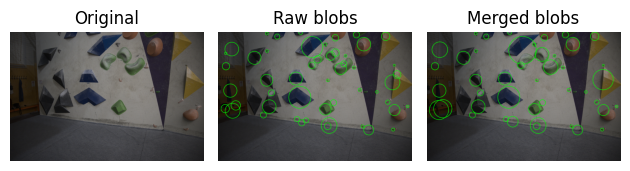

In [14]:
#from std.utils import *
from matplotlib import pyplot as plt


img = cv.imread('/kaggle/input/indoor-climbing-gym-hold-segmentation/sm/001.jpg')

# blob detection
keypoints = detect_blobs(img)
img_blobs = img.copy()
draw_keypoints(img_blobs, keypoints)

# merge blobs that have an overlapping
keypoints = merge_blobs(keypoints)
img_blobs_merged = img.copy()
draw_keypoints(img_blobs_merged, keypoints)                                                     


# display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_blobs[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw blobs')

ax3.imshow(img_blobs_merged[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Merged blobs')

fig.tight_layout()
plt.show()

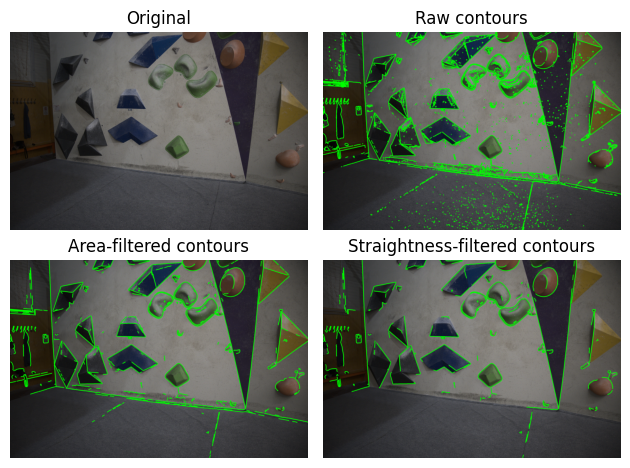

In [15]:
# blur the image for smoother edges
blur = gaussian_blur(img)

# find the contours
edges = canny(blur)
contours = find_contours(edges)

img_contours = img.copy()
draw_contours(img_contours, contours)

contours = filter_size_contours(contours)
img_contours_area = img.copy()
draw_contours(img_contours_area, contours)

contours = filter_straight_contours(contours)
img_contours_straight = img.copy()
draw_contours(img_contours_straight, contours)


# display the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_contours[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw contours')

ax3.imshow(img_contours_area[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Area-filtered contours')

ax4.imshow(img_contours_straight[:, :, ::-1])
ax4.axis('off')
ax4.set_title('Straightness-filtered contours')

fig.tight_layout()
plt.show()

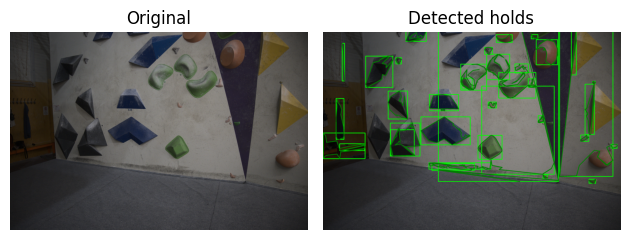

In [16]:
# contours are simplified to speed up the detection
contours = simplify_contours(contours)

# approximate holds by their contours
# returns a dictionary of keypoint-contour
# NOTE that this step can take a few minutes, depending on a number of keypoints
hold_approximations = detect_holds(img, keypoints, contours)

img_holds = img.copy()
draw_contour_boxes(img_holds, list(hold_approximations.values()), color=(0, 255, 0))
draw_contours(img_holds, list(hold_approximations.values()), color=(0, 128, 0))


# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

['detectron2', '.virtual_documents', 'holds_plot.png', 'holds_plot.jpg']


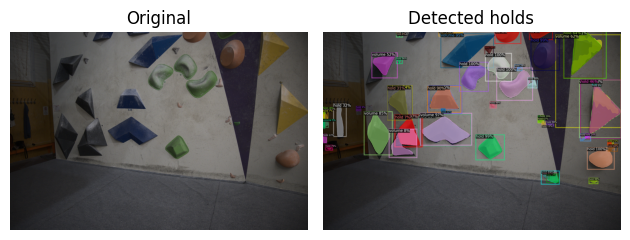

In [21]:
import os
import cv2
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

MODEL_DIRECTORY = "/kaggle/input/indoor-climbing-gym-hold-segmentation/model/"
SAMPLE_IMAGE = "/kaggle/input/indoor-climbing-gym-hold-segmentation/sm/001.jpg"

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file(os.path.join(MODEL_DIRECTORY, "experiment_config.yml"))
cfg.MODEL.WEIGHTS = os.path.join(MODEL_DIRECTORY, "model_final.pth")
cfg.MODEL.DEVICE='cpu'

# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

img = cv2.imread(SAMPLE_IMAGE)
outputs = predictor(img)
v = Visualizer(
    img[:, :, ::-1],
    metadata=metadata
)

out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img_holds = out_predictions.get_image()
# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds)
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.savefig('/kaggle/working/holds_plot.jpg')
print(os.listdir('/kaggle/working'))
plt.show()

